In [1]:
%load_ext autoreload
%autoreload 2


In [1]:
import numpy as np
from mflex.simulate.simulate_boundary import dalmatian
import matplotlib.pyplot as plt

In [2]:
nresol_x = 200
nresol_y = 200
nresol_z = 400
xmin = 0.0
xmax = 2.0  # in units of 10^4 km, therefore corresponds to 20Mm
ymin = 0.0
ymax = 2.0
zmin = 0.0
zmax = 2.0
pixelsize_x = (xmax - xmin) / nresol_x
pixelsize_y = (ymax - ymin) / nresol_y
pixelsize_z = (zmax - zmin) / nresol_z

# Background atmosphere parameters
z0 = 0.2
deltaz = 0.02

b = 1.0
a = 0.22
alpha = 0.5

z_arr = np.arange(nresol_z) * (zmax - zmin) / (nresol_z - 1) + zmin
x_arr = np.arange(nresol_x) * (xmax - xmin) / (nresol_x - 1) + xmin
y_arr = np.arange(nresol_y) * (ymax - ymin) / (nresol_y - 1) + ymin

data_bz = np.zeros((nresol_y, nresol_x))

for ix in range(0, nresol_x):
    for iy in range(0, nresol_y):
        x = x_arr[ix]
        y = y_arr[iy]
        data_bz[iy, ix] = dalmatian(x, y)

In [3]:
from matplotlib import rc, colors

cmap = colors.LinearSegmentedColormap.from_list(
    "cmap",
    (
        # Edit this gradient at https://eltos.github.io/gradient/#cmap=000000-A8A8A8-FFFFFF
        (0.000, (0.000, 0.000, 0.000)),
        (0.500, (0.659, 0.659, 0.659)),
        (1.000, (1.000, 1.000, 1.000)),
    ),
)

In [5]:
# with open("/Users/lilli/Desktop/mflex/mhsflex/testfile.npy", "wb") as file:
#     np.array([nresol_x, nresol_y, nresol_z], dtype=np.int32).tofile(file)
#     np.array([pixelsize_x, pixelsize_y, pixelsize_z], dtype=np.float64).tofile(file)
#     data_bz.tofile(file)
#     x_arr.tofile(file)
#     y_arr.tofile(file)
#     z_arr.tofile(file)

In [8]:
from mhsflex.field2d import Field2dData
from mhsflex.field3d import Field3dData, calculate_magfield
import mhsflex.vis as mhsvis


In [6]:
data2d = Field2dData(nresol_x, nresol_y, nresol_z, nresol_x, pixelsize_x, pixelsize_y, pixelsize_z, x_arr, y_arr, z_arr, data_bz)

In [9]:
data3d = calculate_magfield(data2d, a, b, alpha, z0, deltaz)

In [10]:
from mhsflex.vis import plot

NameError: name 'ax' is not defined

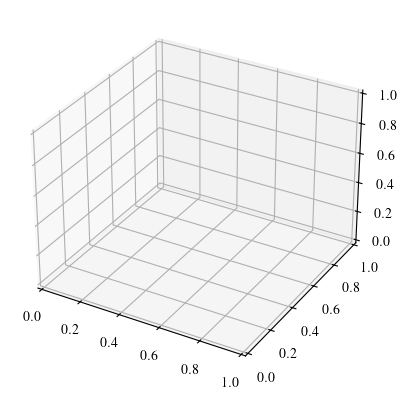

In [11]:
plot(data3d, False, 'los')

In [ ]:
# SDO Example starts here
#
from sunpy.net import Fido, attrs 
import astropy.units as u
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
import numpy as np
from astropy.coordinates import SkyCoord
import sunpy.map
import matplotlib.colors
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
from matplotlib import colors

In [ ]:
result = Fido.search(
    a.Time("2024/5/07 07:30:00", "2024/5/07 07:31"),
    a.Instrument.hmi,
    a.Physobs("LOS_magnetic_field"),
)

downloaded_files = Fido.fetch(result)
path = "/Users/lilli/sunpy/data/hmi_m_45s_2024_05_07_07_31_30_tai_magnetogram.fits"
hmi_image = sunpy.map.Map(path).rotate()
hdr = hmi_image.fits_header

left_corner = SkyCoord(
    Tx=-142 * u.arcsec, Ty=-350 * u.arcsec, frame=hmi_image.coordinate_frame
)
right_corner = SkyCoord(
    Tx=158 * u.arcsec, Ty=-150 * u.arcsec, frame=hmi_image.coordinate_frame
)


dist = hdr["DSUN_OBS"]
pixelsize_x_unit = hdr["CUNIT1"]
pixelsize_y_unit = hdr["CUNIT2"]
pixelsize_x_arcsec = hdr["CDELT1"]
pixelsize_y_arcsec = hdr["CDELT2"]

if not pixelsize_x_unit == pixelsize_y_unit:
    print("Pixelsize units not matchy-matchy")
    raise ValueError
if not pixelsize_x_arcsec == pixelsize_y_arcsec:
    print("Data pixelsizes in x and y direction not matchy-matchy")
    raise ValueError
else:
    pixelsize_radians = pixelsize_x_arcsec / 206265.0
dist_km = dist / 1000.0
pixelsize_Mm = np.floor(pixelsize_radians * dist_km) * 10**-3

hpc_coords = sunpy.map.all_coordinates_from_map(hmi_image)
mask = ~sunpy.map.coordinate_is_on_solar_disk(hpc_coords)
magnetogram_big = sunpy.map.Map(hmi_image.data, hmi_image.meta, mask=mask)

In [ ]:
fig = plt.figure(figsize=(7.2, 4.8))
norm = matplotlib.colors.SymLogNorm(50, vmin=-7.5e2, vmax=7.5e2)
ax1 = fig.add_subplot(121, projection=magnetogram_big)
magnetogram_big.plot(
    axes=ax1,
    cmap=cmap,
    norm=norm,
    annotate=False,
)
magnetogram_big.draw_grid(axes=ax1, color="black", linestyle="dotted", lw=0.2)

for coord in ax1.coords:
    coord.frame.set_linewidth(0)
    coord.set_ticks_visible(False)
    coord.set_ticklabel_visible(False)

magnetogram_big.draw_quadrangle(
    left_corner, top_right=right_corner, edgecolor="black", lw=1
)
magnetogram_small = hmi_image.submap(left_corner, top_right=right_corner)
ax2 = fig.add_subplot(122, projection=magnetogram_small)
im = magnetogram_small.plot(
    axes=ax2,
    norm=norm,
    cmap=cmap,
    annotate=False,
)
ax2.grid(alpha=0)

lon, lat = ax2.coords[0], ax2.coords[1]
lon.frame.set_linewidth(1)
lat.frame.set_linewidth(1)
lon.set_axislabel(
    "Helioprojective Longitude",
)
lon.set_ticks_position("b")
lat.set_axislabel(
    "Helioprojective Latitude",
)
lat.set_axislabel_position("r")
lat.set_ticks_position("r")
lat.set_ticklabel_position("r")

xpix, ypix = magnetogram_big.wcs.world_to_pixel(right_corner)
con1 = ConnectionPatch(
    (0, 1),
    (xpix, ypix),
    "axes fraction",
    "data",
    axesA=ax2,
    axesB=ax1,
    arrowstyle="-",
    color="black",
    lw=0.5,
)
xpix, ypix = magnetogram_big.wcs.world_to_pixel(
    SkyCoord(right_corner.Tx, left_corner.Ty, frame=magnetogram_big.coordinate_frame)
)
con2 = ConnectionPatch(
    (0, 0),
    (xpix, ypix),
    "axes fraction",
    "data",
    axesA=ax2,
    axesB=ax1,
    arrowstyle="-",
    color="black",
    lw=0.5,
)
ax2.add_artist(con1)
ax2.add_artist(con2)

ax2.tick_params(direction="in", length=2, width=0.5)

pos = ax2.get_position().get_points()
cax = fig.add_axes([pos[0, 0], pos[1, 1] + 0.01, pos[1, 0] - pos[0, 0], 0.025])
cbar = fig.colorbar(im, cax=cax, orientation="horizontal")
cbar.locator = matplotlib.ticker.FixedLocator([-1e2, 0, 1e2])
cbar.set_label("LOS Magnetic Field [Gauss]", labelpad=-40, rotation=0)
cbar.update_ticks()
cbar.ax.xaxis.set_ticks_position("top")

plt.show()

nresol_x = magnetogram_small.data.shape[1]
nresol_y = magnetogram_small.data.shape[0]

xmax_Mm = nresol_x * pixelsize_Mm
ymax_Mm = nresol_y * pixelsize_Mm
pixelsize_z_Mm = 90.0 * 10**-3

zmax_Mm = 20000.0 * 10**-3

xmin = np.float64(0.0)  # Minimum value of x in data length scale, not in Mm
ymin = np.float64(0.0)  # Minimum value of y in data length scale, not in Mm
zmin = np.float64(0.0)  # Minimum value of z in data length scale, not in Mm

nresol_z = int(np.floor(zmax_Mm / pixelsize_z_Mm))

z0 = 2000.0 * 10**-3

nf_max = min(nresol_x, nresol_y)

xmax = xmax_Mm
ymax = ymax_Mm
zmax = zmax_Mm
z0 = z0

pixelsize_x = pixelsize_Mm
pixelsize_y = pixelsize_Mm
pixelsize_z = pixelsize_Mm
print("xmax, ymax, zmax", xmax, ymax, zmax)
print("xmax_Mm, ymax_Mm, zmax_Mm", xmax_Mm, ymax_Mm, zmax_Mm)
print("nresol_x, nresol_y, nresol_z", nresol_x, nresol_y, nresol_z)
print("pixelsize_x, pixelsize_x_Mm", pixelsize_x, pixelsize_Mm)
print("pixelsize_y, pixelsize_y_Mm", pixelsize_y, pixelsize_Mm)
print("pixelsize_z, pixelsize_z_Mm", pixelsize_z, pixelsize_Mm)

In [ ]:
# plt.gca().set_axis_off()
# plt.subplots_adjust(top = 1, bottom = 0, right = 1, left = 0,
#             hspace = 0, wspace = 0)
# plt.margins(0,0)
# plt.gca().xaxis.set_major_locator(plt.NullLocator())
# plt.gca().yaxis.set_major_locator(plt.NullLocator())
# plt.savefig("filename.pdf", bbox_inches = 'tight',
#     pad_inches = 0)

In [22]:
from mhsflex.read import read_fits

In [23]:
# Solar orbiter test

name = "solo_L2_phi-hrt-blos_20220307T000609_V01"

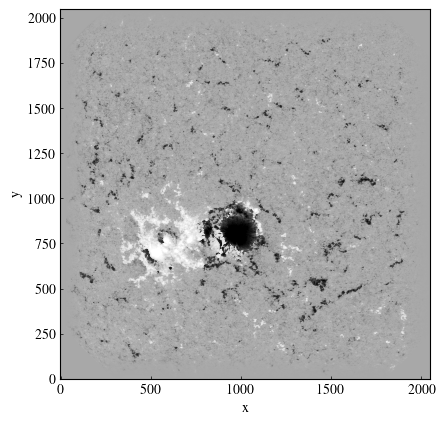

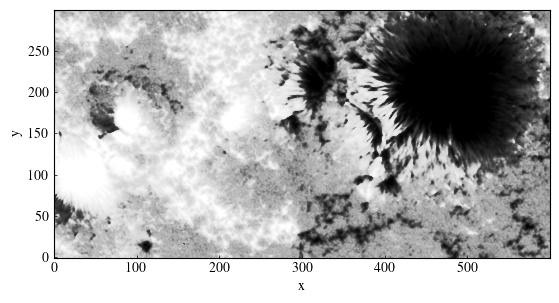

600
300
222
0.18181893257556517
0.18181893257556517
0.09
(600, 300)
(600,)
(300,)
(222,)


In [28]:
read_fits(name)

In [30]:
fex2 = Field3d("solo_L2_phi-hrt-blos_20220307T000609_V01", 0.0, 1.0, 0.0, 2.0, 0.2)

600
300
222
0.18181893257556517
0.18181893257556517
0.09
(300, 600)
(600,)
(300,)
(222,)


In [12]:
fex2.nx

NameError: name 'fex2' is not defined